<a href="https://colab.research.google.com/github/adya-t-07/audio-emotion-recog-cnn/blob/main/audio_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1 Loss: 1.9897
Epoch 2 Loss: 2.0208
Epoch 3 Loss: 1.9263
Epoch 4 Loss: 1.8865
Epoch 5 Loss: 1.9497
Epoch 6 Loss: 1.7799
Epoch 7 Loss: 2.0041
Epoch 8 Loss: 1.9145
Epoch 9 Loss: 1.7739
Epoch 10 Loss: 1.5939
Epoch 11 Loss: 1.9338
Epoch 12 Loss: 1.4670
Epoch 13 Loss: 1.8107
Epoch 14 Loss: 1.5603
Epoch 15 Loss: 2.0968
Epoch 16 Loss: 1.5116
Epoch 17 Loss: 1.6252
Epoch 18 Loss: 1.4637
Epoch 19 Loss: 1.8053
Epoch 20 Loss: 1.6903
Validation Accuracy: 30.00%


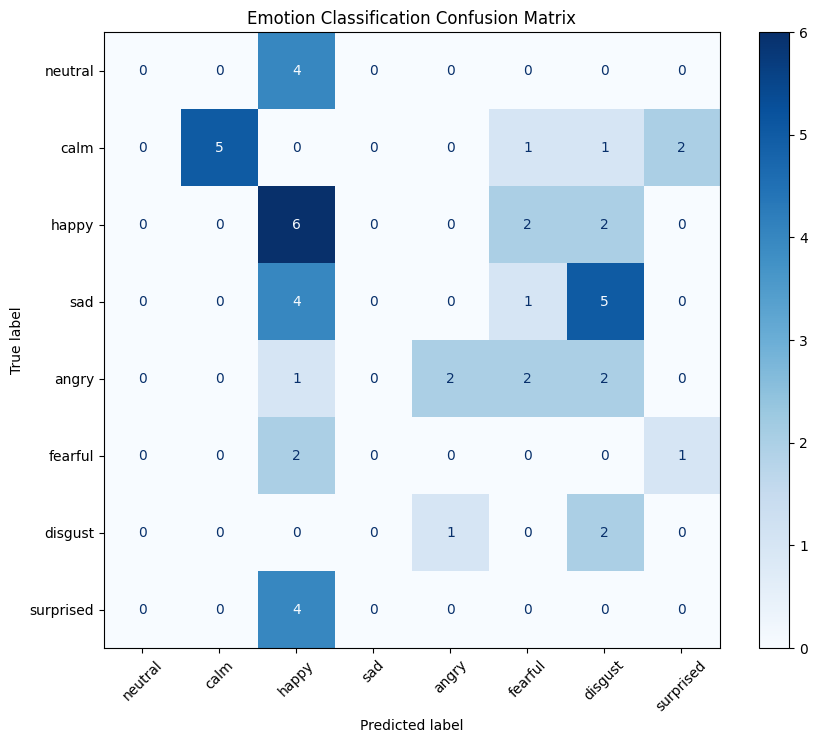

In [8]:
import librosa
import torch
from torch.utils.data import Dataset
import os
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

folder_path = '/content/drive/MyDrive/audio_speech_actors_01-24'

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

class AudioData(Dataset):
  def __init__(self, folder):
    self.folder = folder
    #label map: {'neutral' : 1, 'calm' : 2, etc.}
    self.label_map = {emotion: i for i, emotion in enumerate(emotion_map.values())}

    self.files = []
    #traverses through nested folders to get all audio files
    for root, _, filenames in os.walk(folder):
      for fname in filenames:
        if fname.endswith('.wav'):
          #concatenating root with fname gives the complete path to the file
          self.files.append(os.path.join(root, fname))

  def __getitem__(self, index):
    fname = self.files[index]
    fpath = os.path.join(self.folder, fname)

    label = self.label_map[emotion_map[fname.split('-')[3]]]

    signal, sr = librosa.load(fpath, sr=16000)

    desired_T = 300
    hop_length = 512
    n_fft = 2048
    required_samples = (desired_T - 1) * hop_length + n_fft

    #trimming/padding the audio so that all samples have the same length
    signal_fixed = librosa.util.fix_length(signal, size=required_samples)
    mel_spectrogram = librosa.feature.melspectrogram(y=signal_fixed, sr=sr, hop_length=512, n_mels=128, n_fft=2048)

    #converting power to dB as it gives log values which reduce the large range in power values
    #reference 0 dB is set as the maximum power
    mel_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    #batch normalization
    mel_db = (mel_db - mel_db.mean()) / (mel_db.std())

    mel_tensor = torch.tensor(mel_db, dtype=torch.float32)
    mel_tensor = mel_tensor.unsqueeze(0)

    return mel_tensor, label

  def __len__(self):
    return len(self.files)

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(1, 32, 3, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.Conv2d(32, 64, 3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2,2),
      nn.AdaptiveAvgPool2d((4, 4))
    )
    self.fc = nn.Sequential(
      nn.Linear(64*4*4, 128),
      nn.ReLU(),
      nn.Linear(128, 8)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.view(x.size(0), -1)
    return self.fc(x)


from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import random

######## TESTING AND TRAINING DATA ########
dataset = AudioData(folder_path)

indices = random.sample(range(dataset.__len__()), 100)
train_ds = Subset(dataset, indices)
train_loader = DataLoader(train_ds, batch_size=10, shuffle=True)

indices = random.sample(range(dataset.__len__()), 50)
val_ds = Subset(dataset, indices)
val_loader = DataLoader(val_ds, batch_size=10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

######### TRAINING LOOP ##########
for epoch in range(20):
  model.train()
  for X, y in train_loader:
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
  print(f'Epoch {epoch+1} Loss: {loss.item():.4f}')

######## EVALUATION ##########
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model.eval()

correct = 0
total = 0 #metrics to measure accuracy

y_true = []
y_pred = [] #metrics to create confusion matrix

with torch.no_grad():
  for X, y in val_loader:
    X, y = X.to(device), y.to(device)
    outputs = model(X)
    _, preds = torch.max(outputs, 1)

    correct += (preds == y).sum().item()
    total += y.size(0)

    y_true.extend(y.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())
print(f'Validation Accuracy: {correct / total:.2%}')

class_names = list(emotion_map.values())

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title('Emotion Classification Confusion Matrix')
plt.show()
